In this notebook, I aim to answer:

- Data exploration – What are the most interesting features of the data set? What have you considered and why have you made the decisions you have done?
- Modelling – What process did you follow when modelling sales?  How have you designed your model and what did you account for?
- Conclusions – What are your main findings? How might you use those insights, or your model, to improve Hastings’ pricing? What else would it have been useful to know?

Useful notes: https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
# from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from numpy import mean, std
# from numpy import std
# from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
# from matplotlib import pyplot
from lightgbm import LGBMClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
plt.rcParams["figure.figsize"] = (10,10)

In [2]:
df=pd.read_csv('data/data.csv')
display(df.head(3))

# add id col and exposure
df['row_num'] = np.arange(len(df))
df['Exposure'] = 1

,Driver_Age,Vehicle_Value,Tax,Price,Vehicle_Mileage,Credit_Score,Licence_Length_Years,Date,Marital_Status,Sale
0,48.0,7000.0,41.961971,419.619709,7000.0,366.105677,8.711803,29/05/2016,M,0
1,32.0,8000.0,53.448931,534.489312,6000.0,306.560408,8.754815,03/07/2015,S,0
2,32.0,7000.0,48.042838,480.428376,6000.0,430.070380,6.942515,04/10/2015,M,0


# Data Partitioning

In [93]:
# select 10,000 rows for final model validation
test_df=df.sample(n=10000)

In [3]:
# define training / validation 
# .drop(['Sale'], axis=1)
training_df, validation_df, response_training_df, response_validation_df = train_test_split(df, df['Sale'], test_size=0.2, random_state=1)

In [4]:
# Null Accuracy Score in dataset, training and test
lst = [0] * len(df['Sale'])
print('Dataset Null Accuracy Score:', accuracy_score(df['Sale'],pd.Series(lst)))

lst = [0] * len(response_training_df)
print(f'Training Null Accuracy Score: {accuracy_score(response_training_df, pd.Series(lst))}')

lst = [0] * len(response_validation_df)
print(f'Test Null Accuracy Score: {accuracy_score(response_validation_df, pd.Series(lst))}')

Dataset Null Accuracy Score: 0.30202
Training Null Accuracy Score: 0.299975
Test Null Accuracy Score: 0.3102


# EDA

In [5]:
# duplicates
print(df.shape)
print(df.drop_duplicates().shape)

(50000, 12)
(50000, 12)


In [6]:
# constant cols when sale=1 or 0

In [7]:
# missing
percent_missing = df.isnull().sum() * 100 / len(df)
number_missing = df.isnull().sum()
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing,
                                 'number_missing':number_missing})

display(missing_value_df)

,column_name,percent_missing,number_missing
Driver_Age,Driver_Age,0.988,494
Vehicle_Value,Vehicle_Value,1.018,509
Tax,Tax,0.962,481
Price,Price,0.992,496
Vehicle_Mileage,Vehicle_Mileage,1.072,536
Credit_Score,Credit_Score,1.044,522
Licence_Length_Years,Licence_Length_Years,0.984,492
Date,Date,0.000,0
Marital_Status,Marital_Status,0.976,488
Sale,Sale,0.000,0


In [8]:
# missing values

missing_numerics=['Driver_Age',
 'Vehicle_Value',
 'Tax',
 'Price',
 'Vehicle_Mileage',
 'Credit_Score',
 'Licence_Length_Years']

for i in missing_numerics:
    training_df[i]=training_df[i].fillna(training_df[i].mean())
    validation_df[i]=validation_df[i].fillna(validation_df[i].mean())
    
missing_categorics=['Marital_Status']

for i in missing_categorics:
    
    training_df[i]=training_df[i].fillna('MI')
    validation_df[i]=validation_df[i].fillna('MI')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [9]:
# Feature Engineering

def feature_engineering(df):
    
    # Year Licence obtained
    # Partitioned features
    # Average Credit score per licence length
    # percentage of price that is tax

    # date columns
    df['Year']=pd.to_datetime(df['Date']).dt.year
    df['Month']=pd.to_datetime(df['Date']).dt.month_name()
    df['Day']=pd.to_datetime(df['Date']).dt.day_name()
    df['Year_Month']=pd.to_datetime(df['Date']).dt.year.astype(str)+pd.to_datetime(df['Date']).dt.month.astype(str).str.zfill(2)

    # age_licence_obtained
    df['age_licence_obtained']=round(df['Driver_Age']-df['Licence_Length_Years'],2)
    df['per_life_driving']=round(df['Licence_Length_Years']/df['Driver_Age'],2)
    
    return df

training_df=feature_engineering(training_df)
validation_df=feature_engineering(validation_df)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value i

In [10]:
# categoric cols
cat_cols=['Marital_Status']

# one hot encoding
for i in cat_cols:
    for j in training_df[i].unique():
        training_df[str(i)+'_'+str(j)]=np.where(training_df[i].astype(str)==j,1,0)
        
    for k in validation_df[i].unique():
        validation_df[str(i)+'_'+str(k)]=np.where(validation_df[i].astype(str)==k,1,0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [11]:
# response mean encoding
mean_cols=['Year_Month', 'Day']

def mean_encoder(training_df, validation_df, col, response):

    """ function to mean encode categorical features 
        any missing values are imputed with mode """

    # Create dictionary
    mean_encoding=training_df.groupby(col)[response].mean().to_dict()

    # Apply to train
    training_df[col+'_ME']=training_df[col].replace(mean_encoding)
    training_df[col+'_ME']=training_df[col+'_ME'].fillna(training_df[col+'_ME'].mode()[0])

    # Apply to valid
    validation_df[col+'_ME']=validation_df[col].replace(mean_encoding)
    validation_df[col+'_ME']=validation_df[col+'_ME'].fillna(validation_df[col+'_ME'].mode()[0])        

for i in mean_cols:
    mean_encoder(training_df, validation_df, i, 'Sale')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [12]:
# Correlated Cols

# One Ways

In [13]:
def plot_one_ways(i, diff_band, exposure, obs, target_name, width=0.5):
    
    """
    function to create one way plots
    - diff_band: the x co-ordinates for plots
    - exposure: number of rows per diff_band grouping
    - width: width of columns predefined as 0.5
    - target_name: response to plot as line
    """
    
    plt.bar(diff_band, exposure, width, color='gold', label='Diff', edgecolor='k')
    plt.xticks(rotation=90)
    plt.ylim(0, max(exposure)*3)
    plt.ylabel('Exposure')
    plt.xlabel(f'{i}')
    plt.title(f'One Way Plot of {i}')

    # Line plot
    axes2 = plt.twinx()
    axes2.plot(diff_band, obs, color='fuchsia', marker="s", markeredgecolor='black', label='Actual')
    axes2.set_ylabel(target_name)

    # legend and settings
    plt.legend(loc="upper left")

    plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


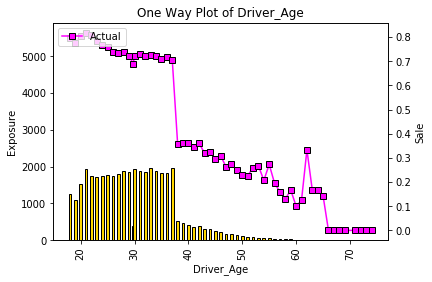

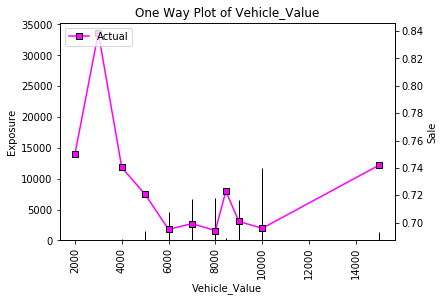

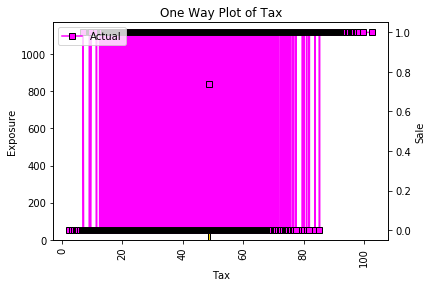

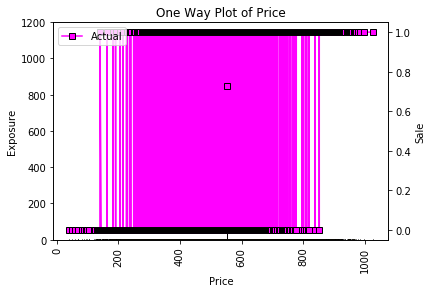

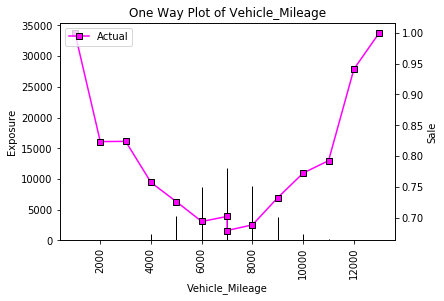

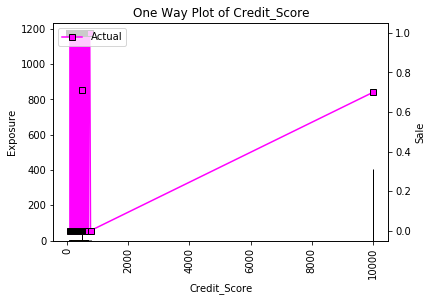

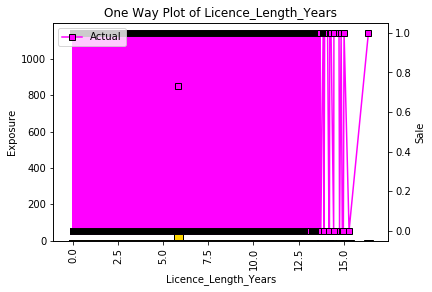

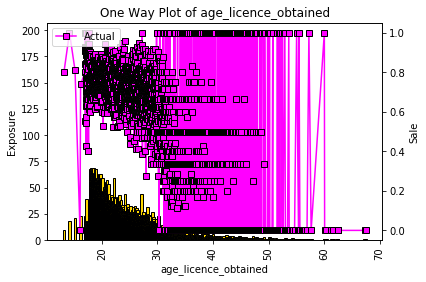

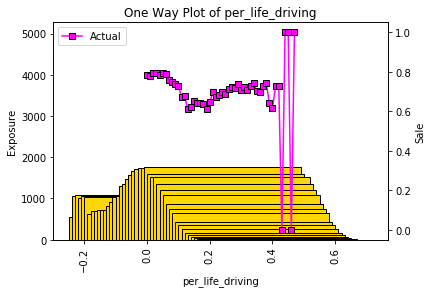

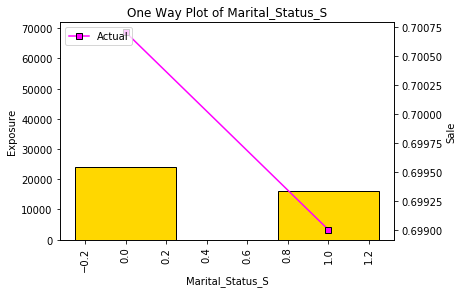

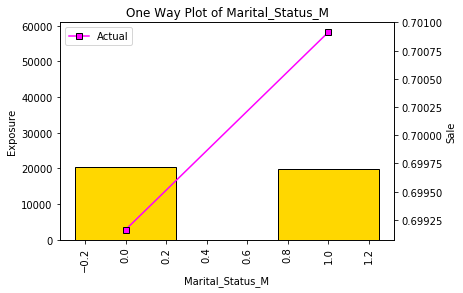

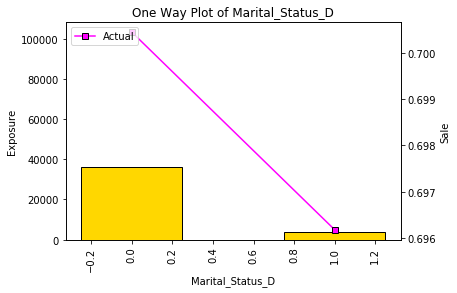

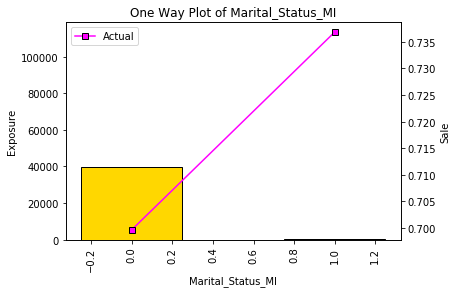

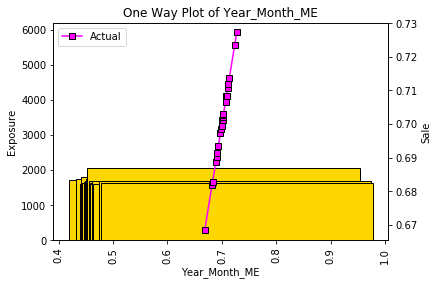

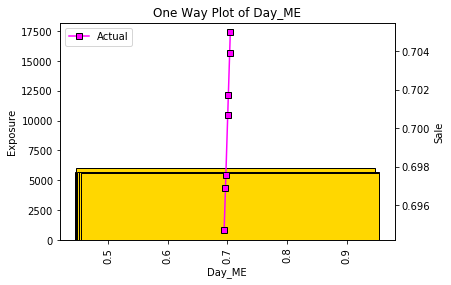

In [17]:
cols=['Driver_Age',
 'Vehicle_Value',
 'Tax',
 'Price',
 'Vehicle_Mileage',
 'Credit_Score',
 'Licence_Length_Years',
#  'Date',
#  'Marital_Status',
#  'Sale',
#  'row_num',
#  'Exposure',
#  'Year',
#  'Month',
#  'Day',
#  'Year_Month',
 'age_licence_obtained',
 'per_life_driving',
 'Marital_Status_S',
 'Marital_Status_M',
 'Marital_Status_D',
 'Marital_Status_MI',
 'Year_Month_ME',
 'Day_ME']

target_name='Sale'

# Plot Original
for i in cols:

    training_df[i]=training_df[i].fillna(-1)
    exposure=training_df.groupby(i)['Exposure'].sum()
    obs=training_df.groupby(i)[target_name].mean()
    diff_band=sorted(set(training_df[i]))
    plot_one_ways(i, diff_band, exposure, obs, target_name)

# Baseline Model

In [20]:
# add constant columns for baseline model using df original factors

original_cols=['Driver_Age',
 'Vehicle_Value',
 'Tax',
 'Price',
 'Vehicle_Mileage',
 'Credit_Score',
 'Licence_Length_Years']
#  'Date',
#  'Marital_Status',
#  'Sale',
#  'row_num',
#  'Exposure',
#  'Year',
#  'Month',
#  'Day',
#  'Year_Month',
#  'age_licence_obtained',
#  'per_life_driving',
#  'Marital_Status_S',
#  'Marital_Status_M',
#  'Marital_Status_D',
#  'Marital_Status_MI',
#  'Year_Month_ME',
#  'Day_ME']

# Logistic Regression
logistic_model=LogisticRegression(max_iter=5000)

# define standard scaler
scaler = StandardScaler()

# transform train data
train_scaled = scaler.fit_transform(training_df[original_cols])

#Fit the model:
logistic_model.fit(train_scaled,response_training_df)

# transform valid
valid_scaled=scaler.transform(validation_df[original_cols])

#Make predictions on training set
train_predictions = logistic_model.predict(train_scaled)
valid_predictions = logistic_model.predict(valid_scaled)

#Print accuracy
accuracy = metrics.accuracy_score(train_predictions,response_training_df)
print("Training Accuracy : %s" % "{0:.3%}".format(accuracy))
accuracy = metrics.accuracy_score(valid_predictions,response_validation_df)
print("Validation Accuracy : %s" % "{0:.3%}".format(accuracy))

f1=f1_score(response_training_df, train_predictions, average=None)
print(f'Training F1 Score: {f1}')
f1=f1_score(response_validation_df, valid_predictions, average=None)
print(f'Validation F1 Score: {f1}')

Training Accuracy : 87.782%
Validation Accuracy : 87.350%
Training F1 Score: [0.78812053 0.91416528]
Validation F1 Score: [0.78678577 0.91007322]


# Differing Modelling Methods

lr training: 0.91 0.004
lr valid: 0.906 0.01
knn training: 0.899 0.004
knn valid: 0.885 0.008
cart training: 0.882 0.002
cart valid: 0.879 0.011
bayes training: 0.897 0.006
bayes valid: 0.892 0.009
rforest training: 0.918 0.004
rforest valid: 0.914 0.007
xgb training: 0.921 0.004
xgb valid: 0.911 0.007
lgbm training: 0.923 0.004
lgbm valid: 0.914 0.007


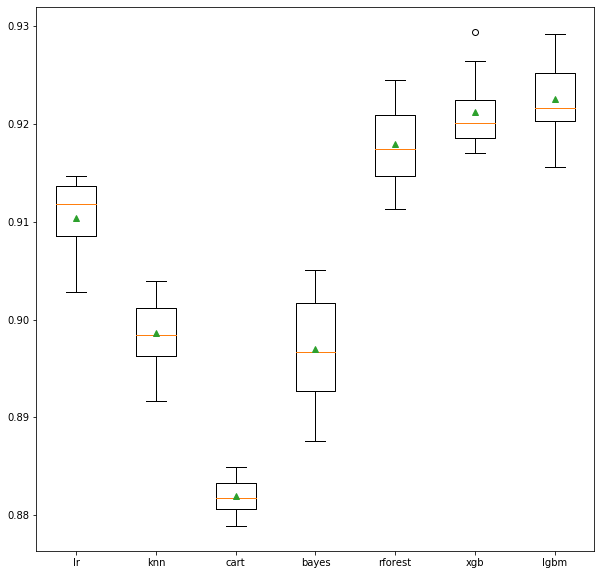

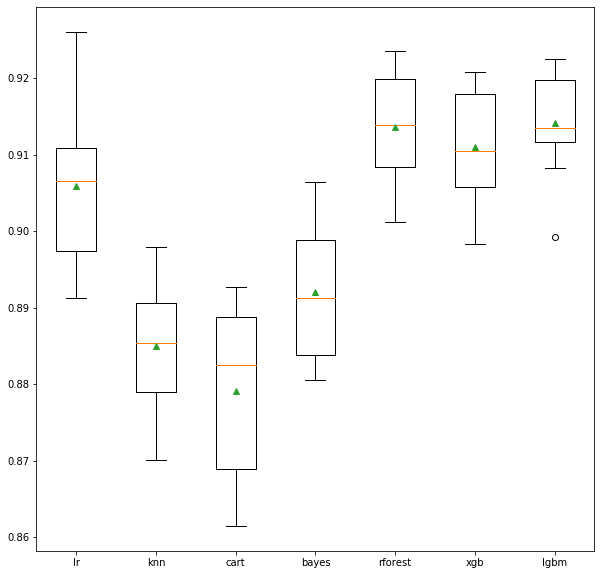

In [28]:
# inputs
X_train=training_df[original_cols]
y_train=response_training_df
X_valid=validation_df[original_cols]
y_valid=response_validation_df
 
# get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['knn'] = KNeighborsClassifier()
    models['cart'] = DecisionTreeClassifier()
    models['bayes'] = GaussianNB()
    models['rforest'] = RandomForestClassifier()
    models['xgb'] = XGBClassifier()
    models['lgbm'] = LGBMClassifier()
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y, X_valid, y_valid):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
    scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
    valid_scores = cross_val_score(model, X_valid, y_valid, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
    return scores, valid_scores

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
valid_results, valid_names = list(), list()
for name, model in models.items():
    scores, valid_scores = evaluate_model(model, X_train, y_train, X_valid, y_valid)
    results.append(scores)
    valid_results.append(valid_scores)
    names.append(name)
    valid_names.append(name)
    print(name, 'training:', round(mean(scores),3), round(std(scores),3))
    print(name, 'valid:', round(mean(valid_scores),3), round(std(valid_scores),3))
    
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

# plot model performance for comparison
pyplot.boxplot(valid_results, labels=valid_names, showmeans=True)
pyplot.show()

# Modelling

Build an XGB Model

In [74]:
cols=['Driver_Age',
 'Vehicle_Value',
 'Tax',
 'Price',
 'Vehicle_Mileage',
 'Credit_Score',
 'Licence_Length_Years',
#  'Date',
#  'Marital_Status',
#  'Sale',
#  'row_num',
#  'Exposure',
#  'Year',
#  'Month',
#  'Day',
#  'Year_Month',
 'age_licence_obtained',
 'per_life_driving',
 'Marital_Status_S',
 'Marital_Status_M',
 'Marital_Status_D',
 'Marital_Status_MI',
 'Year_Month_ME',
 'Day_ME']

In [75]:
# inputs
X_train=training_df[cols]
y_train=response_training_df
X_valid=validation_df[cols]
y_valid=response_validation_df

# XGBoost
xgb_model = XGBClassifier()

# Fit the model
xgb_model.fit(training_df[cols],response_training_df)

#Make predictions on training set
predictions = xgb_model.predict(validation_df[cols])

#Print accuracy
accuracy = metrics.accuracy_score(predictions,response_validation_df)
print("Validation Accuracy : %s" % "{0:.3%}".format(accuracy))

f1=f1_score(response_validation_df, predictions, average=None)
print(f'Validation F1 Score: {f1}')

Validation Accuracy : 88.420%
Validation F1 Score: [0.80485339 0.91767382]


Find most important features from initial build

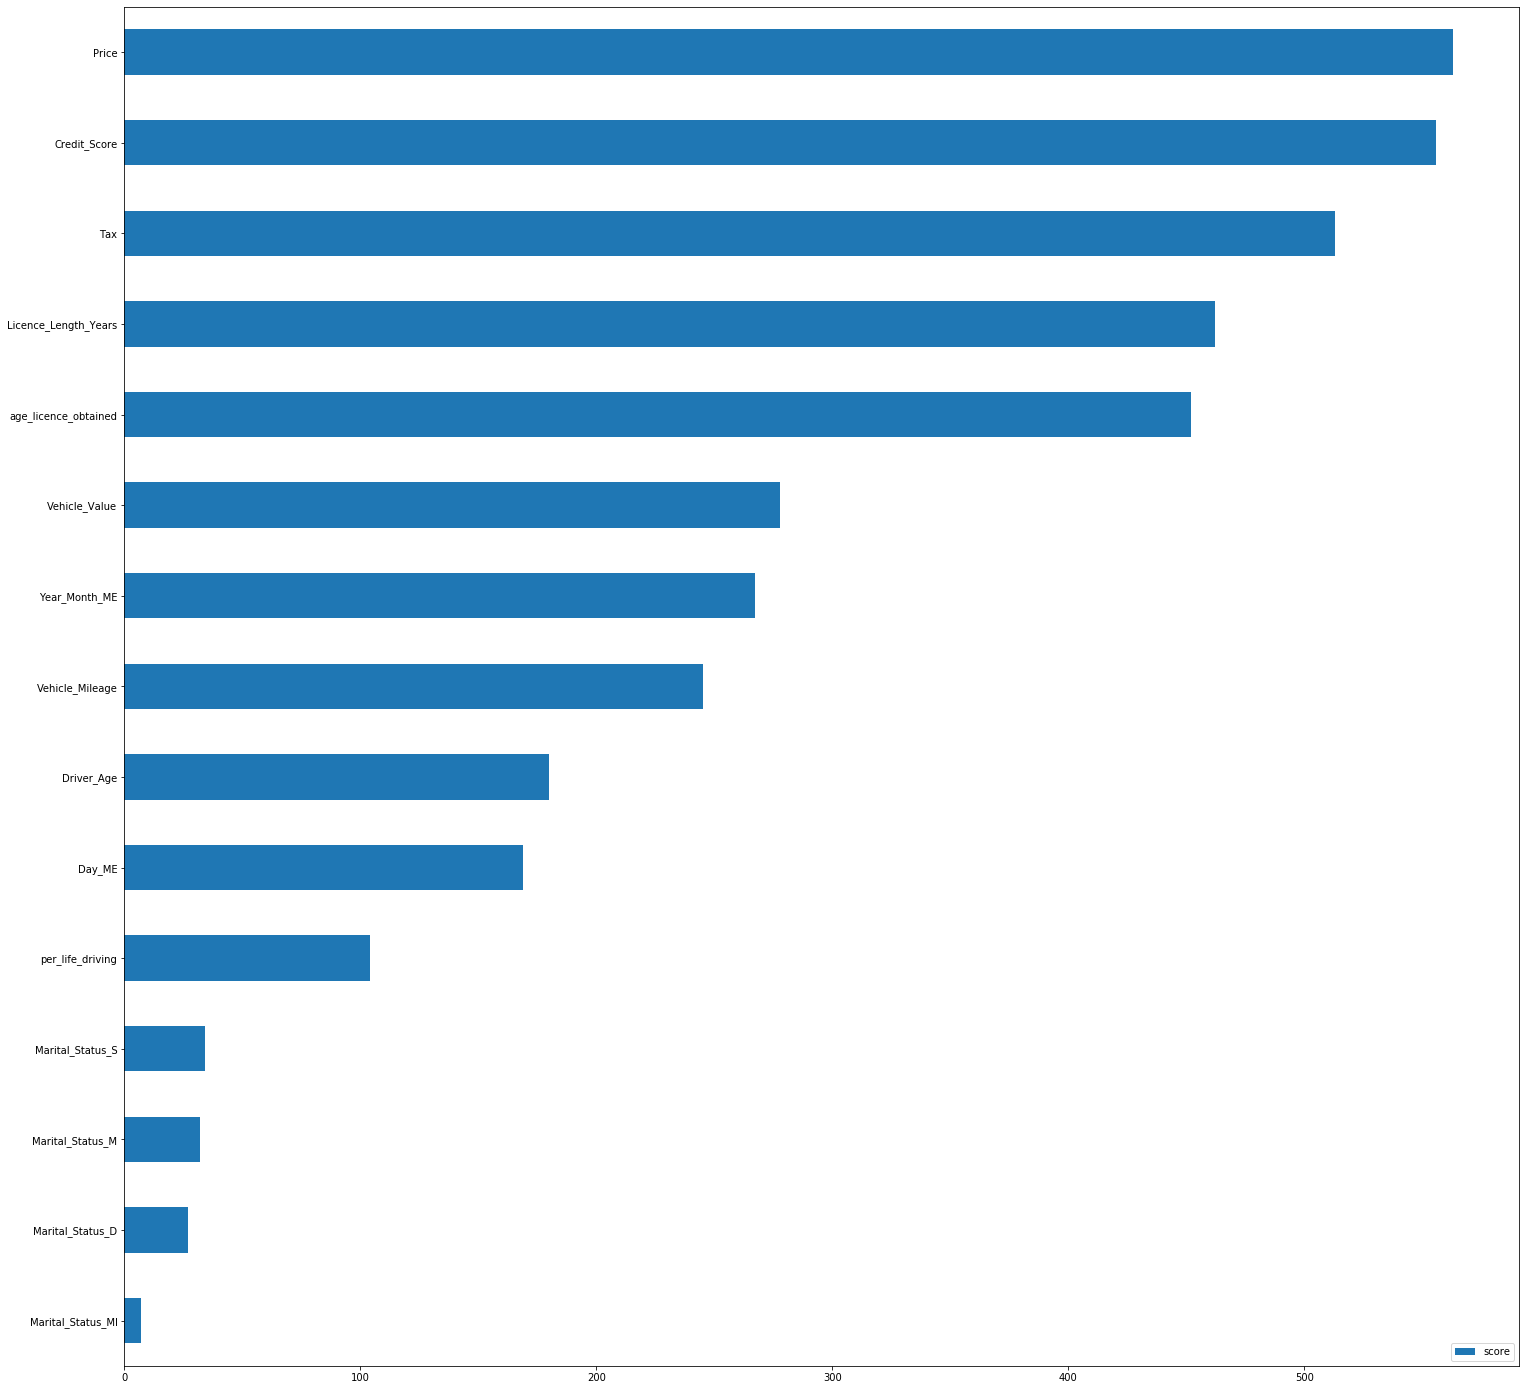

In [76]:
# how many times the feature is used in your trees for splitting purposes.
plt.rcParams["figure.figsize"] = (25, 25)
feature_important = xgb_model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

# from variable importants remove unimportant columns based on 98% capping threshold
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data=data.sort_values(by='score', ascending=False)
data['cum_sum'] = data['score'].cumsum()
data['cum_perc'] = 100*data['cum_sum']/data['score'].sum()
xgb_modelling_cols=list(data.loc[data['cum_perc']<=98].reset_index()['index'])

# plot
plot_data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
plot_data.plot(kind='barh')

In [77]:
# inputs
X_train=training_df[xgb_modelling_cols]
y_train=response_training_df
X_valid=validation_df[xgb_modelling_cols]
y_valid=response_validation_df

# Choose hyperparameter search space
space = {
        'max_depth':hp.choice('max_depth', np.arange(2, 25, 1, dtype=int)),
        'n_estimators':hp.choice('n_estimators', np.arange(50, 12000, 10, dtype=int)),
        'colsample_bytree':hp.quniform('colsample_bytree', 0.4, 0.9, 0.1),
        'min_child_weight':hp.choice('min_child_weight', np.arange(1, 12, 1, dtype=int)),
#         'scale_pos_weight':hp.choice('scale_pos_weight', np.arange(1, scale_pos_weight_val, 1, dtype=int)),   
        'lambda':hp.choice('lambda', np.arange(1, 5, 1, dtype=int)),    
        'subsample':hp.quniform('subsample', 0.6, 1.0, 0.1),
        'gamma':hp.quniform('gamm', 0, 10, 1),
        'objective':'binary:logistic',
        'eta':hp.quniform('eta', 0.01, 0.3, 0.1),
        'eval_metric': 'auc',
    }

def score(params):
    model = XGBClassifier(**params)
    
    model.fit(X_train, 
              y_train, 
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              verbose=False, 
              early_stopping_rounds=25)
    Y_pred_train = model.predict(X_train)
    Y_pred_test = model.predict(X_valid)
    train_score = (-1*roc_auc_score(y_train, Y_pred_train))
    test_score = (-1*roc_auc_score(y_valid, Y_pred_test))
    print('Training loss:', round(abs(train_score),4), 'Test loss:', round(abs(test_score),4))
    return {'loss': test_score, 'status': STATUS_OK}  

def optimize(trials, space):
    
    best = fmin(score, space, algo=tpe.suggest, max_evals=25) # up this amount
    return best

In [78]:
# Optimise
trials = Trials()
best_params = optimize(trials, space)

Training loss:                                        
0.8617                                                
Test loss:                                            
0.854                                                 
Training loss:                                                                  
0.8668                                                                          
Test loss:                                                                      
0.8557                                                                          
Training loss:                                                                   
0.8922                                                                           
Test loss:                                                                       
0.855                                                                            
Training loss:                                                                   
0.8727                                        

100%|██████████| 25/25 [01:55<00:00,  4.61s/trial, best loss: -0.857048333840867]


In [79]:
# Return the best parameters
parameters=space_eval(space, best_params)

# Apply to model
xgb_model = XGBClassifier(colsample_bytree=parameters['colsample_bytree'],
 eta=parameters['eta'],
 eval_metric=parameters['eval_metric'],
 gamma=parameters['gamma'],
 max_depth=parameters['max_depth'],
 min_child_weight=parameters['min_child_weight'],
 n_estimators=parameters['n_estimators'],
#  scale_pos_weight=parameters['scale_pos_weight'],
 objective=parameters['objective'],
 subsample=parameters['subsample'])

xgb_model.fit(
    X_train, 
    y_train,
    eval_metric="auc", 
    eval_set=[(X_train, y_train), (X_valid, y_valid)], 
    verbose=True, 
    early_stopping_rounds=10)

[0]	validation_0-auc:0.61248	validation_1-auc:0.54666
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.90424	validation_1-auc:0.88293
[2]	validation_0-auc:0.93684	validation_1-auc:0.92247
[3]	validation_0-auc:0.93546	validation_1-auc:0.91616
[4]	validation_0-auc:0.94101	validation_1-auc:0.92449
[5]	validation_0-auc:0.94628	validation_1-auc:0.93133
[6]	validation_0-auc:0.94687	validation_1-auc:0.93122
[7]	validation_0-auc:0.94871	validation_1-auc:0.93350
[8]	validation_0-auc:0.94890	validation_1-auc:0.93250
[9]	validation_0-auc:0.94932	validation_1-auc:0.93328
[10]	validation_0-auc:0.95036	validation_1-auc:0.93333
[11]	validation_0-auc:0.95210	validation_1-auc:0.93527
[12]	validation_0-auc:0.95243	validation_1-auc:0.93434
[13]	validation_0-auc:0.95414	validation_1-auc:0.93673
[14]	validation_0-auc:0.95450	validation_1-auc:0.93617
[15]	validation_0-auc:0.9547

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eta=0.1,
              eval_metric='auc', gamma=0.0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.100000001,
              max_delta_step=0, max_depth=9, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=9130, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [81]:
#Make predictions on training set
predictions = xgb_model.predict(X_valid)

#Print accuracy
accuracy = metrics.accuracy_score(predictions,y_valid)
print("Validation Accuracy : %s" % "{0:.3%}".format(accuracy))

f1=f1_score(y_valid, predictions, average=None)
print(f'Validation F1 Score: {f1}')

Validation Accuracy : 88.500%
Validation F1 Score: [0.8060054  0.91827743]


In [ ]:
# elastic_net_model = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 1, max_iter=5000)

# # define standard scaler
# scaler = StandardScaler()

# # transform train data
# train_scaled = scaler.fit_transform(training_df[cols])

# #Fit the model:
# elastic_net_model.fit(train_scaled,response_training_df)

# # transform valid
# valid_scaled=scaler.transform(validation_df[cols])

# # make predictions on training set:
# predictions = elastic_net_model.predict(valid_scaled)

# # print accuracy
# accuracy = metrics.accuracy_score(predictions,response_validation_df)
# print("Validation Accuracy : %s" % "{0:.3%}".format(accuracy))

# f1=f1_score(response_validation_df, predictions, average=None)
# print(f'Validation F1 Score: {f1}')

In [ ]:
# # decision tree
# tree_model = DecisionTreeClassifier()

# #Fit the model:
# tree_model.fit(training_df[cols],response_training_df)

# #Make predictions on training set
# predictions = tree_model.predict(validation_df[cols])

# #Print accuracy
# accuracy = metrics.accuracy_score(predictions,response_validation_df)
# print("Validation Accuracy : %s" % "{0:.3%}".format(accuracy))

# f1=f1_score(response_validation_df, predictions, average=None)
# print(f'Validation F1 Score: {f1}')

In [ ]:
# # Random Forest
# rf_model = RandomForestClassifier() # n_estimators=100,min_samples_split=25, max_depth=7, max_features=2

# #Fit the model
# rf_model.fit(training_df[cols],response_training_df)

# #Make predictions on training set
# predictions = rf_model.predict(validation_df[cols])

# #Print accuracy
# accuracy = metrics.accuracy_score(predictions,response_validation_df)
# print("Validation Accuracy : %s" % "{0:.3%}".format(accuracy))

# f1=f1_score(response_validation_df, predictions, average=None)
# print(f'Validation F1 Score: {f1}')

https://www.kaggle.com/virajbagal/eda-xgb-random-forest-parameter-tuning-hyperopt

In [26]:
# # XGBoost
# xgb_model = XGBClassifier()

# # Fit the model
# xgb_model.fit(training_df[cols],response_training_df)

# #Make predictions on training set
# predictions = xgb_model.predict(validation_df[cols])

# #Print accuracy
# accuracy = metrics.accuracy_score(predictions,response_validation_df)
# print("Validation Accuracy : %s" % "{0:.3%}".format(accuracy))

# f1=f1_score(response_validation_df, predictions, average=None)
# print(f'Validation F1 Score: {f1}')

In [ ]:
# remove noise feats

In [ ]:
# from sklearn.svm import SVC  

# # Instantiate the Support Vector Classifier (SVC)
# svc = SVC(C=1.0, random_state=1, kernel='linear', class_weight='balanced')

# # define standard scaler
# scaler = StandardScaler()

# # transform train data
# train_scaled = scaler.fit_transform(training_df[cols])

# #Fit the model:
# svc.fit(train_scaled,response_training_df)

# # transform valid
# valid_scaled=scaler.transform(validation_df[cols])

# #Make predictions on training set:
# predictions = svc.predict(valid_scaled)

# #Print accuracy
# accuracy = metrics.accuracy_score(predictions,response_validation_df)
# print("Validation Accuracy : %s" % "{0:.3%}".format(accuracy))

# f1=f1_score(response_validation_df, predictions, average=None)
# print(f'Validation F1 Score: {f1}')

In [ ]:
# # compare standalone models for binary classification
# from numpy import mean
# from numpy import std
# from sklearn.datasets import make_classification
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import SVC
# from sklearn.naive_bayes import GaussianNB
# from matplotlib import pyplot
 
# # get the dataset
# # def get_dataset():
# # 	X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# # 	return X, y

# X=training_df[cols]
# y=response_training_df

# # get a list of models to evaluate
# def get_models():
#     models = dict()
#     models['lr'] = LogisticRegression()
#     models['knn'] = KNeighborsClassifier()
#     models['cart'] = DecisionTreeClassifier()
# #     models['svm'] = SVC()
#     models['bayes'] = GaussianNB()
#     models['rforest'] = RandomForestClassifier()
#     models['xgb'] = XGBClassifier()
#     return models
 
# # evaluate a given model using cross-validation
# def evaluate_model(model, X, y):
#     cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#     scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
#     return scores
 
# # get the models to evaluate
# models = get_models()
# # evaluate the models and store results
# results, names = list(), list()
# for name, model in models.items():
#     scores = evaluate_model(model, X, y)
#     results.append(scores)
#     names.append(name)
#     print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

# # plot model performance for comparison
# pyplot.boxplot(results, labels=names, showmeans=True)
# pyplot.show()

# Stacking

In [ ]:
# inputs
X=training_df[cols]
y=response_training_df
X_valid=validation_df[cols]
y_valid=response_validation_df

# get a stacking ensemble of models
def get_stacking():
    
    # define the base models
    level0 = list()
    level0.append(('lr', LogisticRegression()))
    level0.append(('knn', KNeighborsClassifier()))
    level0.append(('cart', DecisionTreeClassifier()))
    level0.append(('svm', SVC()))
    level0.append(('bayes', GaussianNB()))
    level0.append(('rforest', RandomForestClassifier()))
    level0.append(('xgb', XGBClassifier()))
    level0.append(('lgbm', LGBMClassifier()))    
    
    # define meta learner model
    level1 = LogisticRegression()
    
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model
 
# get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['knn'] = KNeighborsClassifier()
    models['cart'] = DecisionTreeClassifier()
    models['svm'] = SVC()
    models['bayes'] = GaussianNB()
    models['rforest'] = RandomForestClassifier()
    models['xgb'] = XGBClassifier()
    models['lgbm'] = LGBMClassifier()
    models['stacking'] = get_stacking()
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y, X_valid, y_valid):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
    scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
    valid_scores = cross_val_score(model, X_valid, y_valid, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
    return scores, valid_scores

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
valid_results, valid_names = list(), list()
for name, model in models.items():
    scores, valid_scores = evaluate_model(model, X, y, X_valid, y_valid)
    results.append(scores)
    valid_results.append(valid_scores)
    names.append(name)
    valid_names.append(name)
    print(name, 'training:', round(mean(scores),3), round(std(scores),3))
    print(name, 'valid:', round(mean(valid_scores),3), round(std(valid_scores),3))

In [ ]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

# plot model performance for comparison
pyplot.boxplot(valid_results, labels=valid_names, showmeans=True)
pyplot.show()

# score on test

# Interpretation

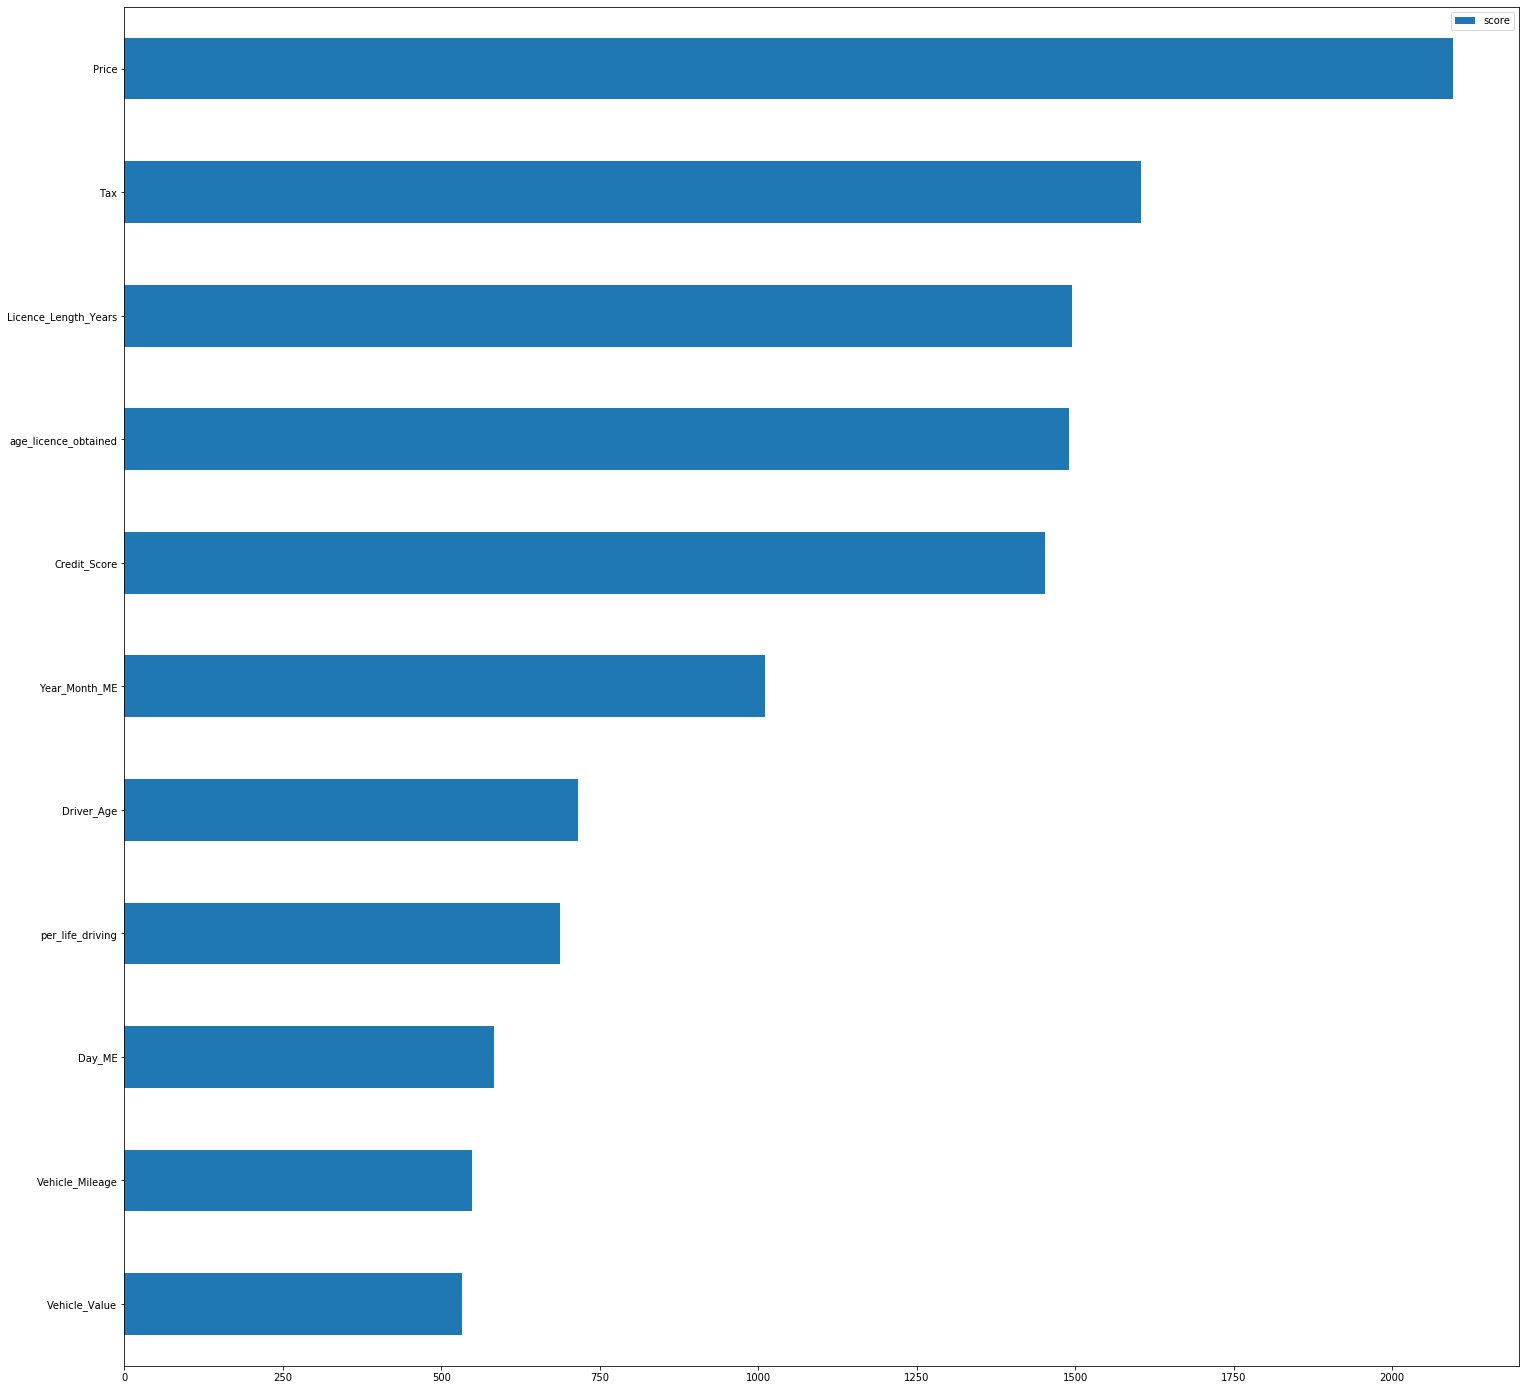

In [82]:
# how many times the feature is used in your trees for splitting purposes.
plt.rcParams["figure.figsize"] = (25, 25)
feature_important = xgb_model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

# plot
plot_data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
plot_data.plot(kind='barh')

In [ ]:
# pdp 
# ice plots
# feature important
# optimal threshold
# https://www.kaggle.com/dansbecker/partial-dependence-plots

# Conclusions

In [ ]:
for name, model in models.items():
    print(name, model)

In [ ]:
# add training validation and test
# what is missing?
# vehicle value at new / vehicle value when bought
# claims history
# occupation
# vehicle type
# geographical factors
# exposure period
# telematics
# excess
# gender
# Age
# id column / identifier
# time of quote
# difference in live data vs modelled data
# selection biases
# which features can be used for modelling based on protected characteristics?
# are there any duplicaste quotes which we don't know about?